In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_models.basic import LinearData
from conformal_prediction.basic import SplitConformal, QuantileConformal
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict

In [21]:
weights=np.array([8, 4, 0.5, -0.5, 8, -8, -4, -3, 1, 5])
lineardata = LinearData(n=10000, weights=weights)
lineardata.X_y_split(y='Y')

In [63]:
plot = None
type = 'full'
B = 1000

def IOU(conformal_sets_all, conformal_sets_j): 
    loss = []
    for i in range(len(conformal_sets_all)):
        tmp = (max(0, conformal_sets_all[i][0]-conformal_sets_j[i][0])+
                max(0, conformal_sets_j[i][1]-conformal_sets_all[i][1]))/(max(conformal_sets_all[i][1], conformal_sets_j[i][1])-min(conformal_sets_all[i][0], conformal_sets_j[i][0]))
        loss.append(tmp)
    return sum(loss)

boot_cov = defaultdict(list)
boot_size = defaultdict(list)
boot_IoU = defaultdict(list)

for i in range(B):

    if i % 50 == 0:
        print(i)

    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
    pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)
    
    for variable in lineardata.calib_data_X.columns:
        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, lineardata.test_data_y)
        IoU = IOU(pred_all, pred_j)

        boot_cov[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size])
        boot_IoU[variable].extend([IoU])

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


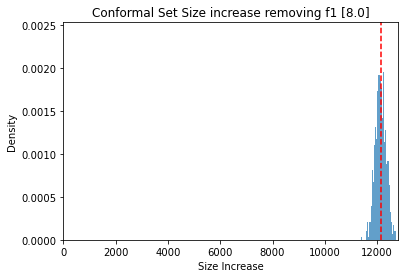

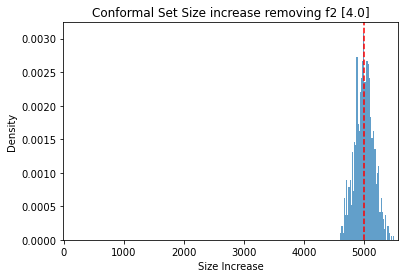

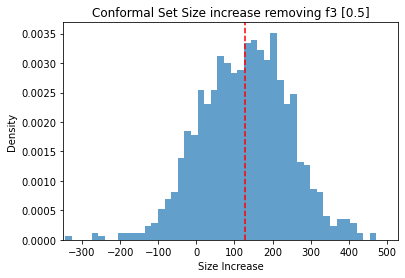

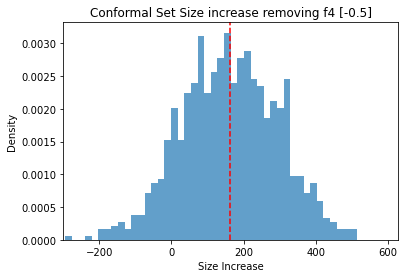

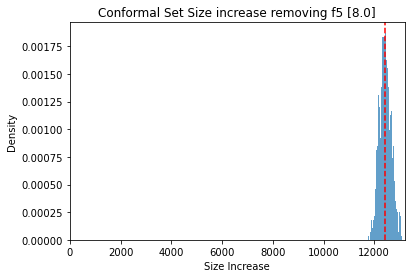

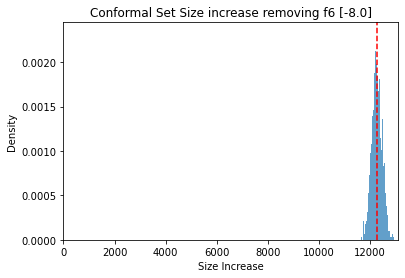

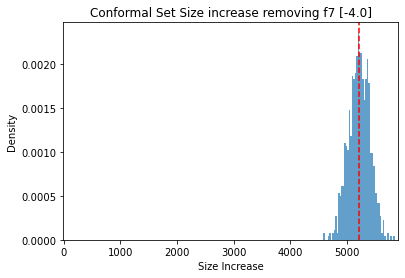

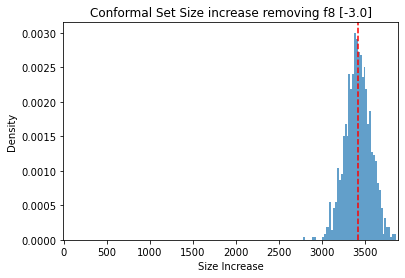

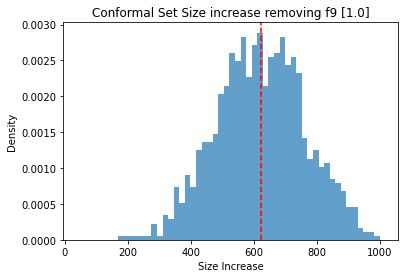

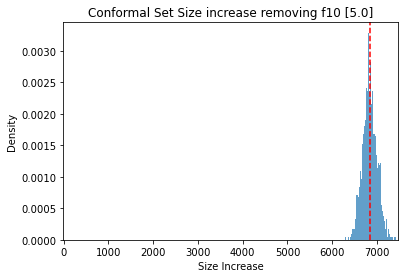

In [64]:
import numpy as np
from matplotlib import pyplot as plt

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images\Linear_data\conformal_set_size_increase_'+variable)
    plt.show()

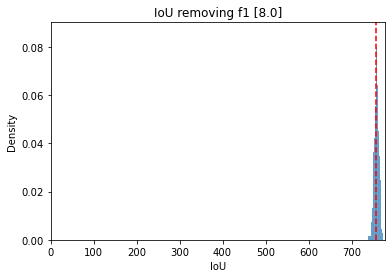

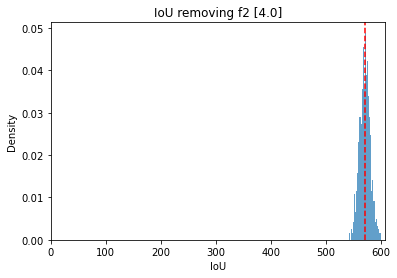

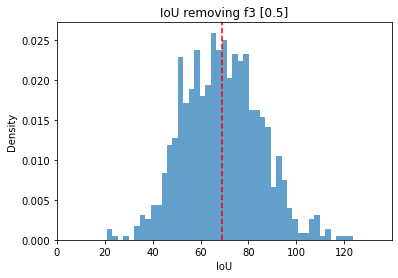

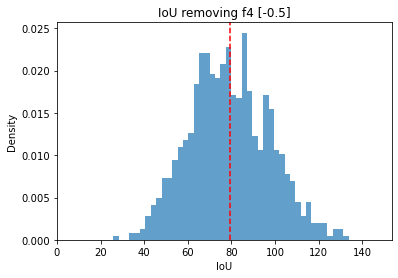

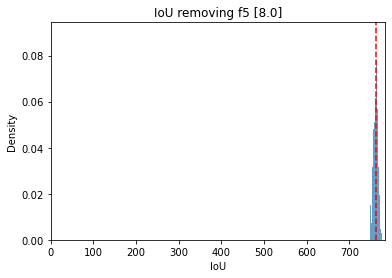

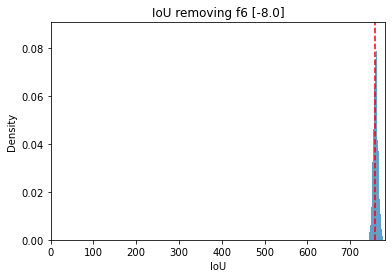

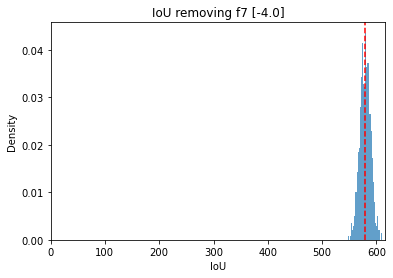

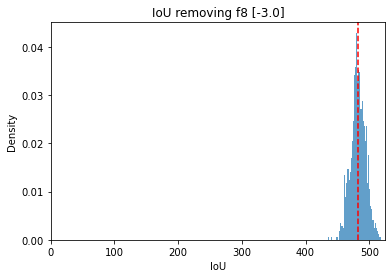

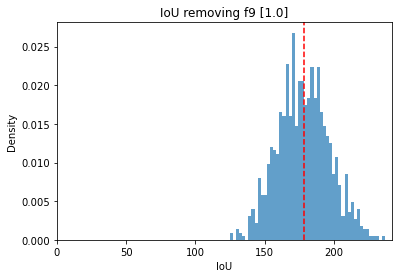

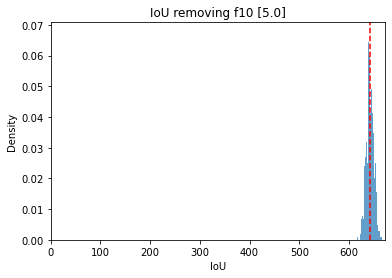

In [65]:
import numpy as np
from matplotlib import pyplot as plt

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data = boot_IoU[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([0, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('IoU removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('IoU')
    plt.ylabel('Density')
    plt.savefig('images\Linear_data\IoU_'+variable)
    plt.show()

In [66]:
# Let's see of we can find any trend using a linear model which should be easier than in the LOCO Data (which was sinusoidal data)

plot = None
type = 'full'
B = 1000

trend = defaultdict(list) 
y_true_displacement_all = defaultdict(list)
y_true_displacement_j = defaultdict(list)

for i in range(B):
    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
    pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)

    for variable in lineardata.calib_data_X.columns:

        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, lineardata.test_data_y)

        for i in range(len(pred_all)):
            trend[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-(pred_j[i][1]+pred_j[i][0])/2])
            y_true_displacement_all[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-lineardata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval
            y_true_displacement_j[variable].extend([(pred_j[i][1]+pred_j[i][0])/2-lineardata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')
            plt.plot(x, lineardata.test_data_y.iloc[:plot].tolist(), 'go')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

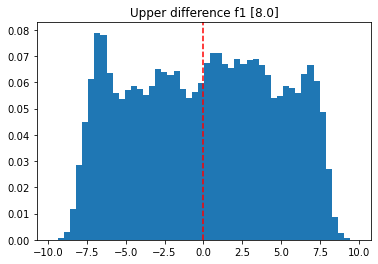

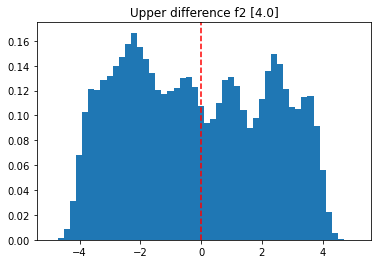

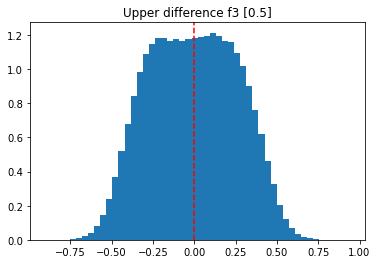

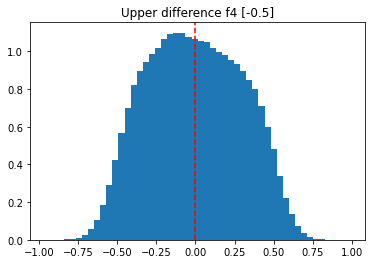

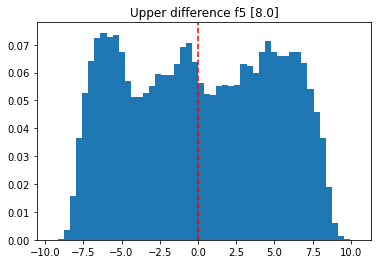

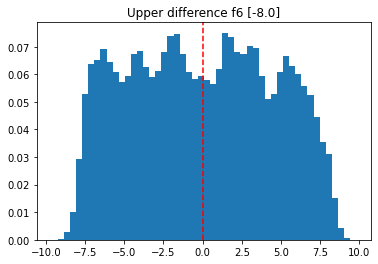

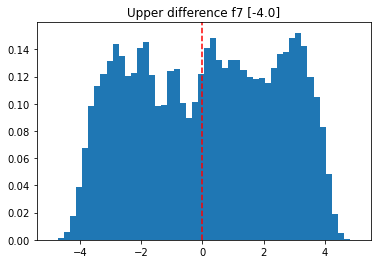

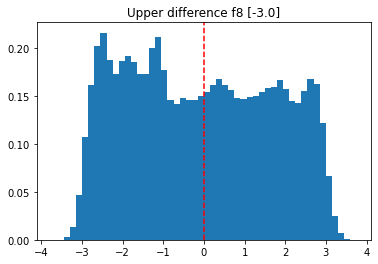

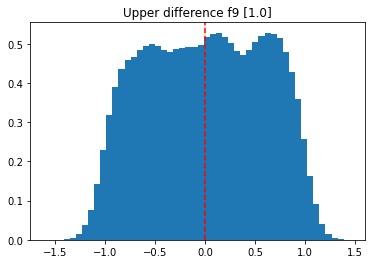

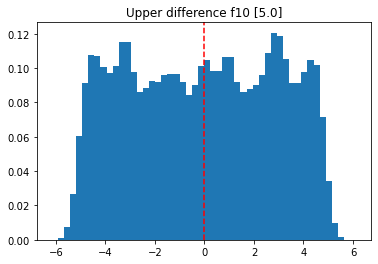

In [67]:
for i, variable in enumerate(lineardata.calib_data_X.columns):

    plt.hist(trend[variable], density=True, bins=50)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Upper difference ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig(r'images\Linear_data\trend_'+variable+'.png')
    plt.show()

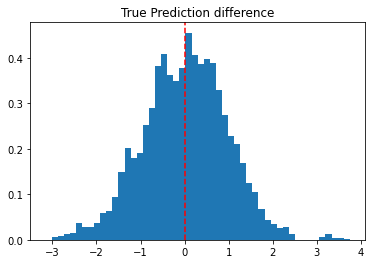

In [68]:
plt.hist(y_true_displacement_all[variable], density=True, bins=50)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('True Prediction difference')
plt.savefig(r'images\Linear_data\true_diff.png')
plt.show()

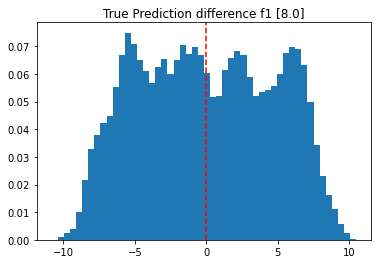

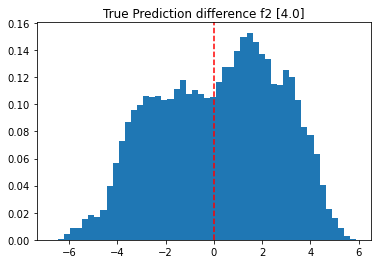

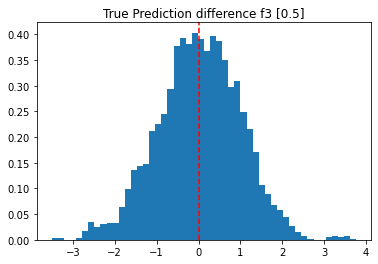

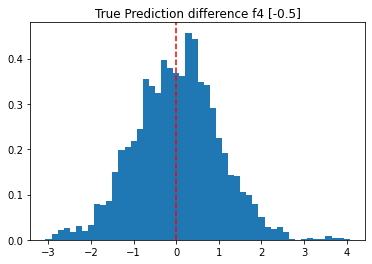

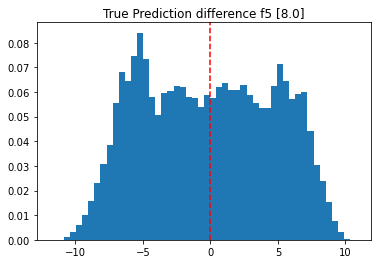

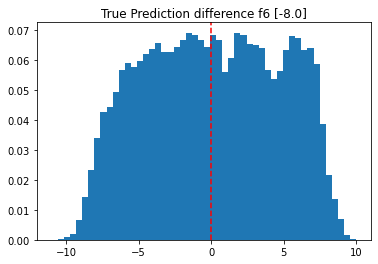

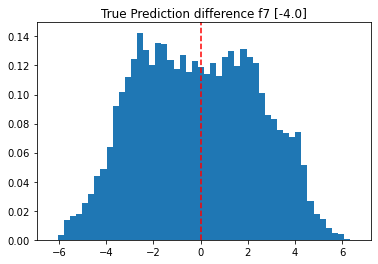

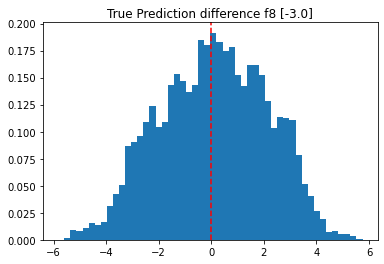

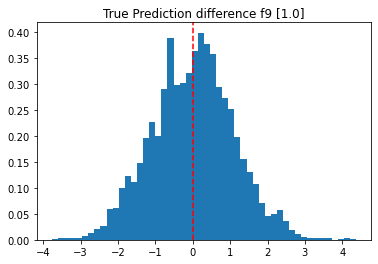

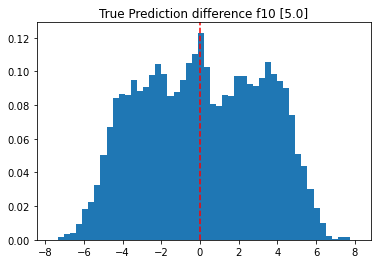

In [69]:
for i, variable in enumerate(lineardata.calib_data_X.columns):

    plt.hist(y_true_displacement_j[variable], density=True, bins=50)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('True Prediction difference ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig(r'images\Linear_data\j_true_diff_'+variable+'.png')
    plt.show()

In [91]:
# What happens if we go over different alpha values?
plot = None
type = 'full'
B = 100

average_size = defaultdict(list)

for variable in ['f1', 'f3', 'f6']:
    print(variable)
    for alpha in np.arange(0.6, 1, 0.01):
        if (alpha*100) % 10 == 0:
            print(alpha)
        temp = 0
        for i in range(B):
            conformal_predictor = SplitConformal(alpha=1-alpha)
            lambda_all, model_all = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
            pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_all, lambda_conformal=lambda_all)
            cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)

            conformal_predictor_j = SplitConformal(alpha=1-alpha)

            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

            lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
            pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
            cov_j, size_j = conformal_predictor_j.evaluate(pred_j, lineardata.test_data_y)

            temp += size_j-size
        average_size[variable].extend([temp/B])

f1
0.6
0.7000000000000001
f3
0.6
0.7000000000000001
f6
0.6
0.7000000000000001


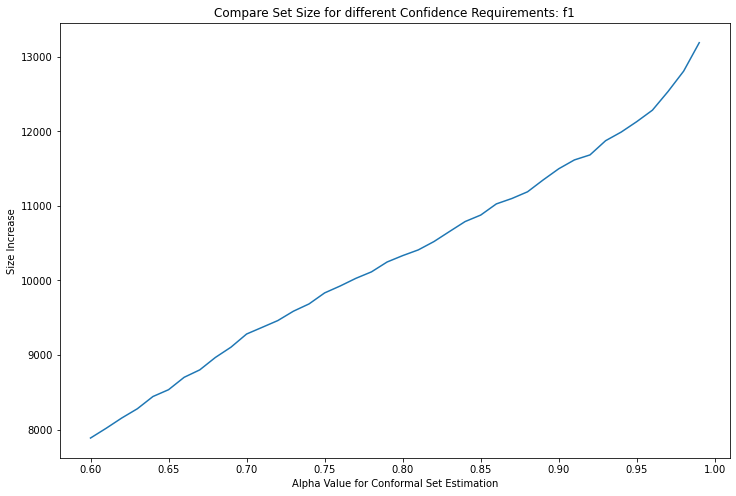

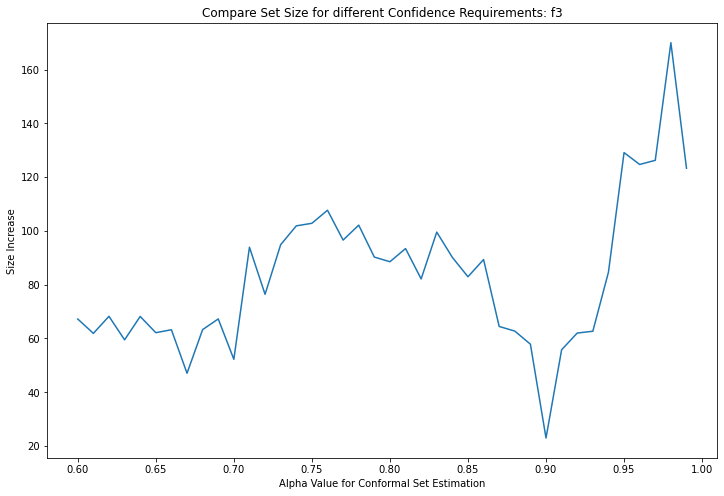

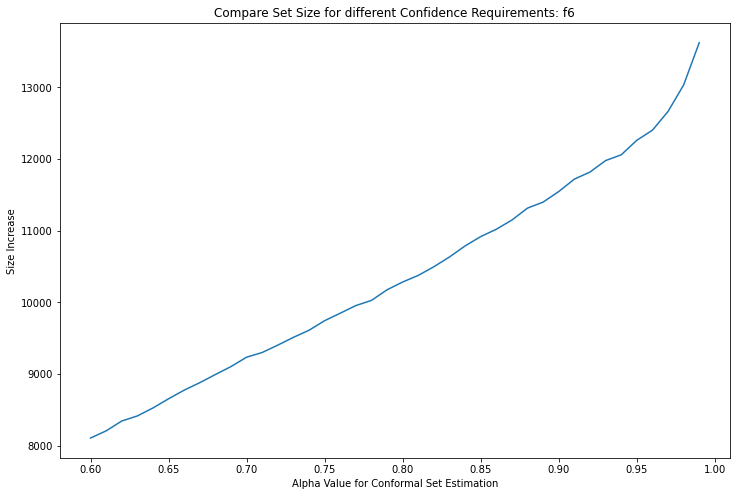

In [93]:
for variable in ['f1', 'f3', 'f6']:
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0.6, 1, 0.01), average_size[variable])
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable)
    plt.show();

In [5]:
# Let's try to review this same method but using a Quantile Regressor as model and therefore for the Conformal Predictor too

weights=np.array([8, 4, 0.5, -0.5, 8, -8, -4, -3, 1, 5])
lineardata = LinearData(n=1000, weights=weights)
lineardata.X_y_split(y='Y')


0
Time for models:  41.54375648498535
[-16.55214525   9.79661002   7.32158429  -6.9098626    7.84527904
   7.52264566   7.66355704  -9.03560389  18.72678535  -3.32604814
 -10.0607439   10.91551512 -11.87314961  15.91350232  -4.92871121
   0.03295399  -0.50325038   4.29232098   8.28052929   7.92093851
  -8.34813557  19.7857084    7.67832231  -2.25716662  15.92885438
   6.82180047  -1.80985215  10.27132388  -7.84976665  -0.88487928
   3.95824607  10.74006348  -3.42502439   4.84915986 -18.07628885
  -1.17814109   5.91789616  -9.08172013   3.84754097   1.14672653
  -3.42871733   6.57865442   5.94448271   1.80570506   0.66270566
   4.49970489 -20.48692598  -3.30627463  -6.79885752 -11.86845569
  12.0135529    8.37239201 -11.42662668   0.69669137  -7.54644645
  16.28688599  15.05386632  18.77857516 -11.40567993 -12.73395597
   7.09444654   0.17698508  11.21131299   7.4426347    7.85312162
   4.13932094   5.00168426  20.40824566  -2.22852591  10.38203534
  -0.03246357  -7.16067084  -2.5683783

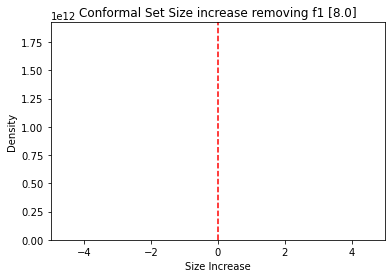

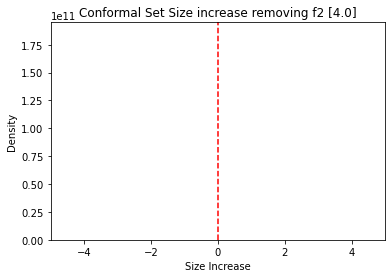

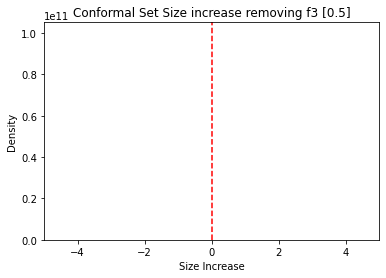

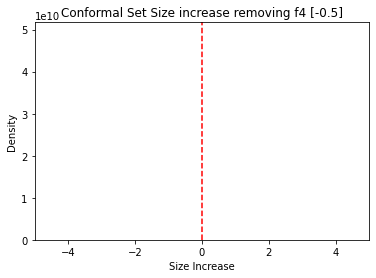

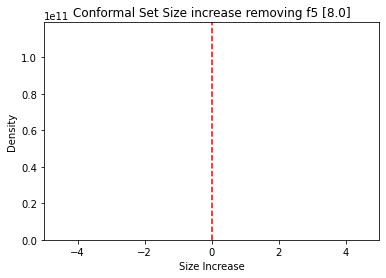

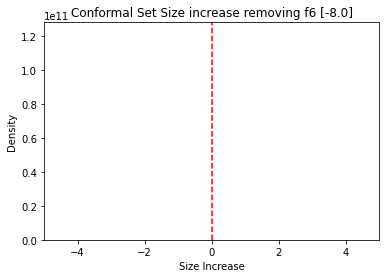

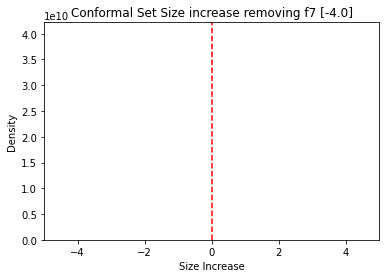

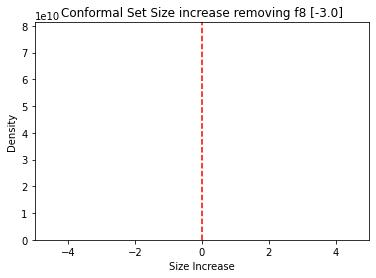

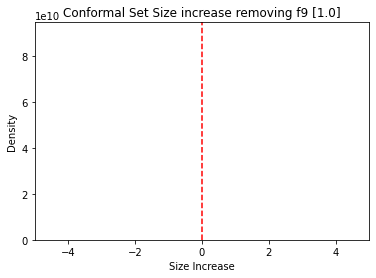

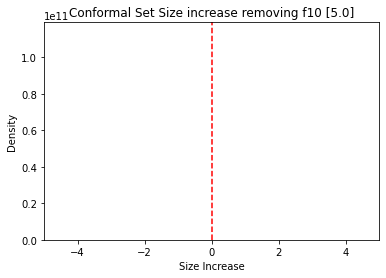

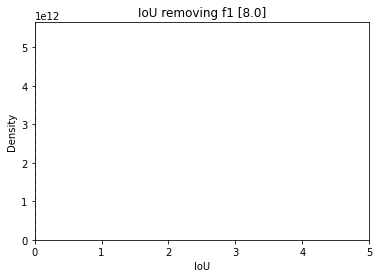

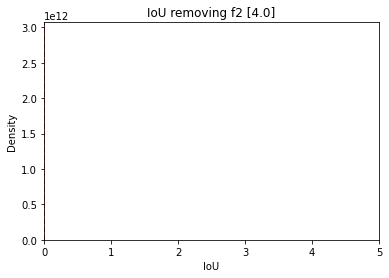

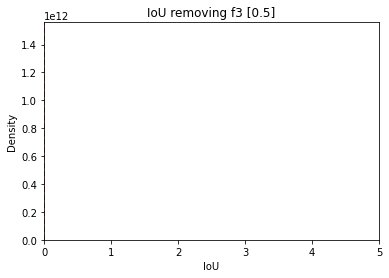

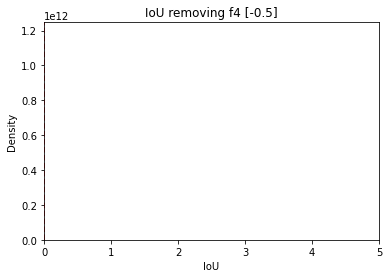

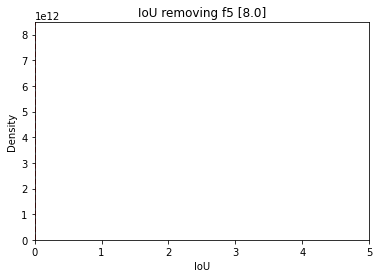

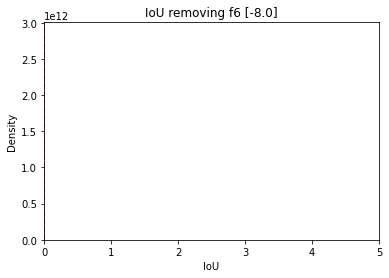

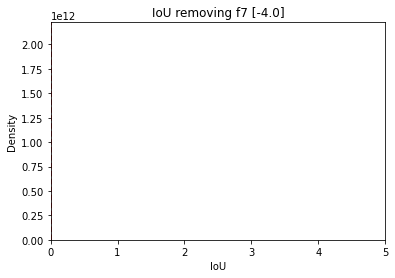

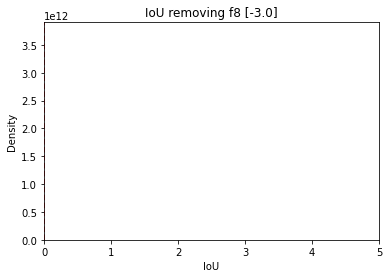

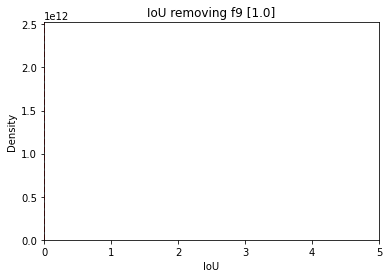

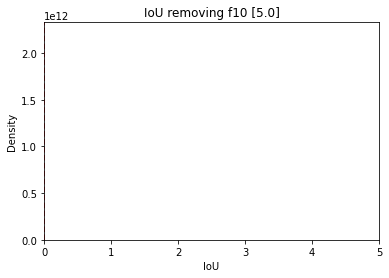

In [4]:
from sklearn.linear_model import QuantileRegressor
import time

plot = None
type = 'full'
B = 5
alpha_model = 0.05

def IOU(conformal_sets_all, conformal_sets_j): 
    loss = []
    for i in range(len(conformal_sets_all)):
        tmp = (max(0, conformal_sets_all[i][0]-conformal_sets_j[i][0])+
                max(0, conformal_sets_j[i][1]-conformal_sets_all[i][1]))/(max(conformal_sets_all[i][1], conformal_sets_j[i][1])-min(conformal_sets_all[i][0], conformal_sets_j[i][0]))
        loss.append(tmp)
    return sum(loss)

boot_cov = defaultdict(list)
boot_size = defaultdict(list)
boot_IoU = defaultdict(list)

for i in range(B):

    print(i)

    weights=np.array([8, 4, 0.5, -0.5, 8, -8, -4, -3, 1, 5])
    lineardata = LinearData(n=1000, weights=weights)
    lineardata.X_y_split(y='Y')

    start = time.time()
    reg_upper = QuantileRegressor(quantile=1-alpha_model).fit(lineardata.train_data_X, lineardata.train_data_y)
    reg_lower = QuantileRegressor(quantile=alpha_model).fit(lineardata.train_data_X, lineardata.train_data_y)

    for variable in lineardata.train_data_X.columns:

        simple_conformal = QuantileConformal(alpha=0.05)
        lambda_all = simple_conformal.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model_upper=reg_upper, model_lower=reg_lower)
        pred_all = simple_conformal.predict(data=lineardata.test_data_X, model_upper=reg_upper, model_lower=reg_lower, lambda_conformal=lambda_all)
        cov_all, size_all = simple_conformal.evaluate(pred=pred_all, true_data=lineardata.test_data_y, plot=False)

        data_X_j = copy.copy(lineardata.calib_data_X)
        data_X_j[variable] = 0
        data_X_test_j = copy.copy(lineardata.test_data_X)
        data_X_test_j[variable] = 0

        lambda_j = simple_conformal.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model_upper=reg_upper, model_lower=reg_lower)
        pred_j = simple_conformal.predict(data=data_X_test_j, model_upper=reg_upper, model_lower=reg_lower, lambda_conformal=lambda_j)
        cov_j, size_j = simple_conformal.evaluate(pred=pred_j, true_data=lineardata.test_data_y, plot=False)
        IoU = IOU(pred_all, pred_j)

        boot_cov[variable].extend([cov_j])
        boot_size[variable].extend([size_j-size_all])
        boot_IoU[variable].extend([IoU])

import numpy as np
from matplotlib import pyplot as plt

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data = boot_size[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.savefig('images\Linear_data\quantile_conformal_set_size_increase_'+variable)
    plt.show()

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data = boot_IoU[variable] 

    # fixed bin size
    bins = np.arange(min(data), max(data), (max(data)-min(data))/50) # fixed bin size

    plt.xlim([0, max(data)+5])

    plt.hist(data, bins=bins, alpha=0.7, density=True)
    plt.axvline(x=np.mean(data), color='red', linestyle='--')
    plt.title('IoU removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('IoU')
    plt.ylabel('Density')
    plt.savefig('images\Linear_data\quantile_IoU_'+variable)
    plt.show()

In [6]:
boot_size

defaultdict(list,
            {'f1': [5.4569682106375694e-12,
              1.2732925824820995e-11,
              -9.094947017729282e-13,
              -9.094947017729282e-13,
              3.637978807091713e-12],
             'f2': [-1.3642420526593924e-11,
              4.501998773775995e-11,
              9.094947017729282e-13,
              -2.2282620193436742e-11,
              0.0],
             'f3': [-3.54702933691442e-11,
              -1.6689227777533233e-10,
              -4.547473508864641e-13,
              -1.9099388737231493e-11,
              -2.2737367544323206e-12],
             'f4': [1.687112671788782e-10,
              -8.503775461576879e-11,
              -9.094947017729282e-13,
              4.1382008930668235e-11,
              5.1386450650170445e-11],
             'f5': [-1.0595613275654614e-10,
              -6.912159733474255e-11,
              -5.4569682106375694e-12,
              4.092726157978177e-12,
              0.0],
             'f6': [4.774847184307